In [1]:
import scanpy as sc
#import numpy as np
#import pandas as pd
#sc.settings.verbosity = 3
#sc.logging.print_versions()

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import anndata2ri
anndata2ri.activate()

In [3]:
data_dir = '../data/'
adata = sc.read(data_dir+'processed/merged_adata.h5ad')
#sc.pp.subsample(adata, 0.3)

In [4]:
adata

AnnData object with n_obs × n_vars = 11829 × 13006 
    obs: 'G2M_score', 'S_score', 'barcode', 'batch', 'cell_ontology_class', 'log_counts', 'method', 'mt_frac', 'n_counts', 'n_genes', 'phase', 'sID', 'sample', 'sex', 'size_factors', 'tissue', 'louvain'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_id'
    uns: 'cell_ontology_class_colors', 'louvain_colors', 'method_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [5]:
ro.r('library(Seurat)')
ro.r('library(scater)')

array(['scater', 'ggplot2', 'SingleCellExperiment',
       'SummarizedExperiment', 'DelayedArray', 'BiocParallel',
       'matrixStats', 'Biobase', 'GenomicRanges', 'GenomeInfoDb',
       'IRanges', 'S4Vectors', 'BiocGenerics', 'parallel', 'stats4',
       'Seurat', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U20')

In [6]:
ro.globalenv['adata'] = adata

In [7]:
ro.r('sobj = as.Seurat(adata, counts = "counts", data = "X")')
ro.r('batch_list = SplitObject(sobj, split.by = "method")')

FACS,[RTYPES.S4SXP]
droplet,[RTYPES.S4SXP]


In [8]:
ro.r('anchors = FindIntegrationAnchors('+
        'object.list = batch_list, '+
        'anchor.features = 10000,'+
        'scale = T,'+
        'l2.norm = T,'+
        'dims = 1:30,'+
        'k.anchor = 5,'+
        'k.filter = 200,'+
        'k.score = 30,'+
        'max.features = 200,'+
        'eps = 0)'
    )

R object with classes: ('AnchorSet',) mapped to:

In [137]:
ro.r('integrated = IntegrateData('+
        'anchorset = anchors,'+
        'new.assay.name = "integrated",'+
        'features = NULL,'+
        'features.to.integrate = NULL,'+
        'dims = 1:100,'+
        'k.weight = 100,'+
        'weight.reduction = NULL,'+
        'sd.weight = 1,'+
        'sample.tree = NULL,'+
        'preserve.order = F,'+
        'do.cpp = T,'+
        'eps = 0,'+
        'verbose = T)'
    )

R object with classes: ('Seurat',) mapped to:

In [138]:
integrated = ro.r('as.SingleCellExperiment(integrated)')

In [139]:
integrated

AnnData object with n_obs × n_vars = 11829 × 3329 
    obs: 'G2M_score', 'S_score', 'barcode', 'batch', 'cell_ontology_class', 'log_counts', 'method', 'mt_frac', 'n_counts', 'n_genes', 'phase', 'sID', 'sample', 'sex', 'size_factors', 'tissue', 'louvain', 'nCount_RNA', 'nFeature_RNA', 'ident'

In [140]:
import os
import sys
sys.path.append(os.path.abspath("../"))
import utils

In [141]:
integrated.X

<11829x3329 sparse matrix of type '<class 'numpy.float32'>'
	with 17939698 stored elements in Compressed Sparse Row format>

In [142]:
utils.summarize_counts(integrated)

In [143]:
sc.pp.pca(integrated)
sc.pp.neighbors(integrated)
sc.tl.umap(integrated)

/home/m/muellermi/bin/miniconda3/envs/sc_tutorial/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


... storing 'batch' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'method' as categorical
... storing 'phase' as categorical
... storing 'sID' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'tissue' as categorical
... storing 'louvain' as categorical


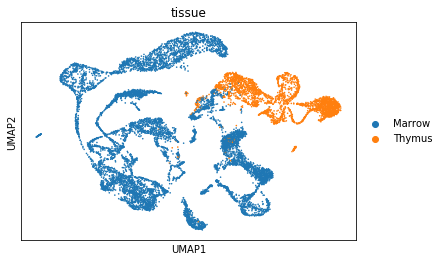

In [144]:
sc.pl.umap(integrated, color='tissue')